In [ ]:
import deepxde as dde
from deepxde.backend import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D


In [22]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [23]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [24]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [25]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2540, num_boundary=80, num_initial=160)

In [26]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [27]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000699 s



In [8]:
losshistory, train_state = model.train(iterations=15000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.20e-03, 2.02e-02, 6.10e-01]    [6.20e-03, 2.02e-02, 6.10e-01]    []  
1000      [4.24e-02, 3.39e-04, 5.43e-02]    [4.24e-02, 3.39e-04, 5.43e-02]    []  
2000      [3.41e-02, 9.46e-05, 4.46e-02]    [3.41e-02, 9.46e-05, 4.46e-02]    []  
3000      [1.50e-02, 1.50e-04, 1.59e-02]    [1.50e-02, 1.50e-04, 1.59e-02]    []  
4000      [7.27e-03, 3.54e-05, 5.39e-03]    [7.27e-03, 3.54e-05, 5.39e-03]    []  
5000      [4.33e-03, 1.88e-05, 2.84e-03]    [4.33e-03, 1.88e-05, 2.84e-03]    []  
6000      [2.44e-03, 8.88e-06, 1.88e-03]    [2.44e-03, 8.88e-06, 1.88e-03]    []  
7000      [1.83e-03, 6.17e-06, 1.36e-03]    [1.83e-03, 6.17e-06, 1.36e-03]    []  
8000      [3.67e-03, 3.80e-05, 1.16e-03]    [3.67e-03, 3.80e-05, 1.16e-03]    []  
9000      [1.36e-03, 3.60e-06, 9.52e-04]    [1.36e-03, 3.60e-06, 9.52e-04]    []  
10000     [1.15e-03, 3.40e-06, 8.19e-04]    [1.15e-03, 3.40e-

In [9]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000812 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [6.73e-04, 1.49e-06, 5.03e-04]    [6.73e-04, 1.49e-06, 5.03e-04]    []  

Best model at step 15000:
  train loss: 1.18e-03
  test loss: 1.18e-03
  test metric: []

'train' took 0.025537 s



In [ ]:
# dde.optimizers.set_NNCG_options(rank=50, mu=1e-1)
# model.compile("NNCG")
# losshistory, train_state = model.train(iterations=1000, display_every=100)

Saving loss history to c:\Users\A_structure\Coding\bmcs_ml\bmcs_ml\explanatory_notebooks\DeepXDe\loss.dat ...
Saving training data to c:\Users\A_structure\Coding\bmcs_ml\bmcs_ml\explanatory_notebooks\DeepXDe\train.dat ...
Saving test data to c:\Users\A_structure\Coding\bmcs_ml\bmcs_ml\explanatory_notebooks\DeepXDe\test.dat ...


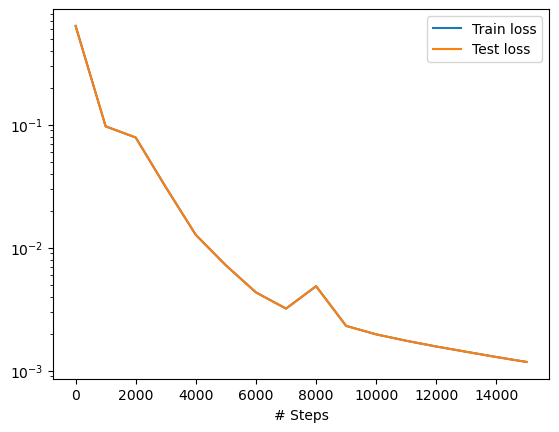

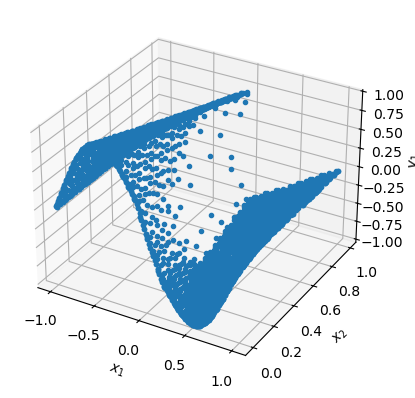

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [ ]:
model.save("burgersnet")

In [28]:
model.restore("burgersnet-15000.pt")

In [29]:
def gen_testdata():
    data = np.load("../DeepXDe/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

X, y_true = gen_testdata()


In [30]:
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.01594975
L2 relative error: 0.03075742308458646


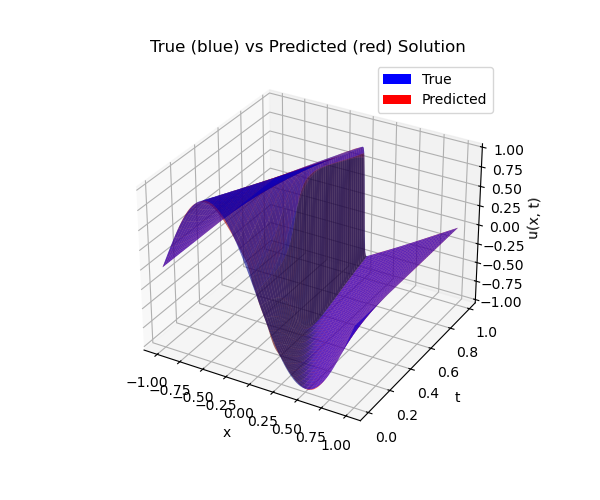

In [ ]:

# Reconstruct grids
x_unique = np.unique(X[:, 0])
t_unique = np.unique(X[:, 1])
X_grid, T_grid = np.meshgrid(x_unique, t_unique)

# Reshape true and predicted values to grid shape
Y_true_grid = y_true.reshape(len(t_unique), len(x_unique))
Y_pred_grid = y_pred.reshape(len(t_unique), len(x_unique))

# Plot in one 3D diagram
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# True solution surface
ax.plot_surface(X_grid, T_grid, Y_true_grid, color='blue', alpha=0.6, label='True')
# Predicted solution surface
ax.plot_surface(X_grid, T_grid, Y_pred_grid, color='red', alpha=0.6, label='Predicted')

# Labels and title
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
ax.set_title("True (blue) vs Predicted (red) Solution")

# Matplotlib doesn't handle 3D legends well; work around it
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='True'),
    Patch(facecolor='red', label='Predicted')
]
ax.legend(handles=legend_elements)

plt.show()


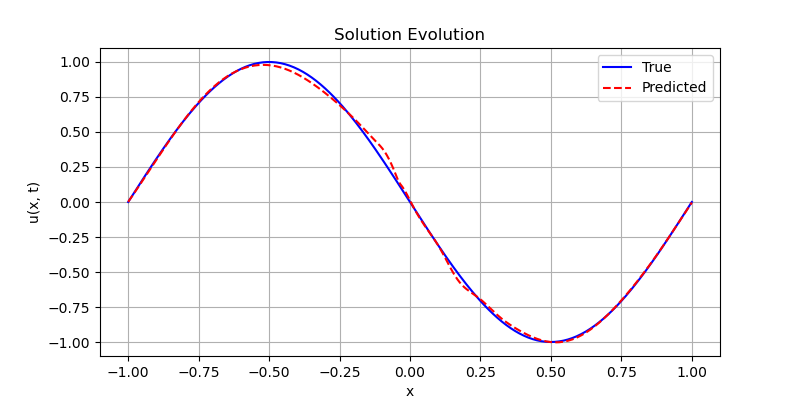

In [ ]:
%matplotlib widget

# Reconstruct spatial and temporal grid
x = np.unique(X[:, 0])
t = np.unique(X[:, 1])

# Reshape true and predicted into (nt, nx)
nx = len(x)
nt = len(t)
y_true_plot = y_true.reshape(nt, nx)
y_pred_plot = y_pred.reshape(nt, nx)

# Set up the figure and axis
fig2, ax2 = plt.subplots(figsize=(8, 4))
line_true, = ax2.plot(x, y_true_plot[0], label="True", color='blue')
line_pred, = ax2.plot(x, y_pred_plot[0], label="Predicted", color='red', linestyle='--')
ax2.set_xlabel("x")
ax2.set_ylabel("u(x, t)")
ax2.set_ylim(np.min(y_true_plot) - 0.1, np.max(y_true_plot) + 0.1)
ax2.set_title("Solution Evolution")
ax2.legend()
ax2.grid(True)

# Animation function
def animate(i):
    line_true.set_ydata(y_true_plot[i])
    line_pred.set_ydata(y_pred_plot[i])
    ax2.set_title(f"u(x, t) Evolution | t = {t[i]:.2f}")
    return line_true, line_pred

ani = animation.FuncAnimation(
    fig2, animate, frames=nt, interval=100, blit=False
)

plt.show()
